In [1]:
from collections import namedtuple
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dipy.core.gradients import gradient_table
from dipy.data import get_fnames, default_sphere
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti

In [15]:
labels = pd.read_excel(r"F:\Uni\master\teamproject\raw_Data\Data specification.xlsx")
labels

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format
0,298129,094_S_4282,AD,M,90,25,DTI,Axial DTI,Original,4/17/2012,DCM
1,376313,052_S_5062,AD,F,71,24,DTI,Axial DTI,Original,2013-12-06 00:00:00,DCM
2,1184057,022_S_6013,AD,F,63,103,DTI,Axial DTI,Original,6/21/2019,DCM
3,380961,027_S_4802,AD,M,84,28,DTI,Axial DTI,Original,7/16/2013,DCM
4,1186912,129_S_6763,AD,F,82,1,DTI,Axial DTI,Original,7/15/2019,DCM
5,250176,003_S_4136,AD,M,67,22,DTI,Axial DTI,Original,2011-10-08 00:00:00,DCM
6,254902,003_S_4142,AD,F,90,22,DTI,Axial DTI,Original,8/31/2011,DCM
7,261479,094_S_4089,AD,M,74,24,DTI,Axial DTI,Original,10/18/2011,DCM
8,1161685,029_S_6289,CN,F,58,102,DTI,Axial DTI,Original,4/30/2019,DCM
9,829304,002_S_1280,CN,F,81,101,DTI,Axial DTI,Original,3/13/2017,DCM


In [117]:
InputData = namedtuple("InputData", ("data", "affine", "gtab"))


def load_data(folder: Path, ident: str) -> InputData:
    hardi_fname, hardi_bval_fname, hardi_bvec_fname = [str(folder / (ident + end)) for end in [".nii.gz", ".bval", ".bvec"]]
    data, affine = load_nifti(hardi_fname)

    bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
    gtab = gradient_table(bvals, bvecs)
    
    return InputData(data, affine, gtab)


In [119]:
mask = load_nifti(r"F:\Uni\master\teamproject\masks\002_S_1261_mask.nii.gz")[0].astype(np.bool)
data = load_data(Path(r"F:\Uni\master\teamproject\preprocessed"), "002_S_1261").data


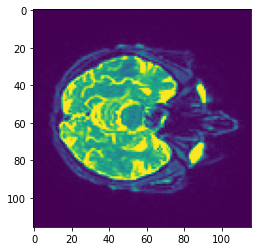

In [120]:
plt.imshow(data[:, :, 30, 0])


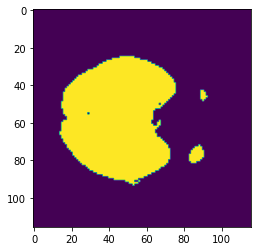

In [121]:
plt.imshow(mask[:, :, 30,])


In [75]:
data[mask == False] = np.zeros(data.shape[-1])

In [122]:
def load_masks(folder: Path, ident: str):
    mask, affine = load_nifti(folder / (ident + "_mask.nii.gz"))
    mask = mask.astype(np.bool)
    return mask

In [193]:
def mask_data(inputs):
    input_data: InputData = inputs[0]
    mask: np.ndarray = inputs[1]
    input_data.data[mask == False] = np.zeros(input_data.data.shape[-1])
    return input_data

In [194]:
CSD_Peaks = namedtuple("CSD_Peaks", ("peak_model_file", "peak_model"))

def peaks_from_data(save_foler: Path, inputs):
    input_data: InputData = inputs[0]
    subject: str = inputs[1] 
    
    from dipy.data import default_sphere
    from dipy.reconst.csdeconv import auto_response, ConstrainedSphericalDeconvModel
    from dipy.direction import peaks_from_model
    from dipy.io.peaks import save_peaks, save_nifti
    from datetime import datetime
    
    print(f"{datetime.now()}: Fitting CSD Model for subject {subject}")
    
    response, ratio = auto_response(input_data.gtab, input_data.data, roi_radius = 10, fa_thr=0.7)
    
    csd_model = ConstrainedSphericalDeconvModel(input_data.gtab, response)

    pam =  peaks_from_model(model=csd_model,
                            data=input_data.data,
                            sphere=default_sphere,
                           relative_peak_threshold=0.5,
                           min_separation_angle=25,
                           parallel=True)
    
    filename = str(folder / subject)
    
    save_peaks(filename + ".h5", pam)
    save_nifti(filename + ".nii.gz", pam)
    
    print(f"saved sucessfully: {filename}")
    return CSD_Peaks(filename, pam)

In [196]:
from functools import partial
subjects_to_data = partial(load_data, Path(r"F:\Uni\master\teamproject\preprocessed"))
subjects_to_mask = partial(load_masks, Path(r"F:\Uni\master\teamproject\masks"))
data_to_peaks = partial(peaks_from_data, Path(r"F:\Uni\master\teamproject\peaks"))



def get_pipeline(subjects):
    return zip(
        map(data_to_peaks, 
            zip(
                map(mask_data,
                    zip(
                        map(subjects_to_data, subjects), map(subjects_to_mask, subjects))
                   ),
                subjects
                )
           ),
        labels.Subject
    )


In [197]:
list(labels.groupby(["Sex", "Group"]))

[(('F', 'AD'),
     Image Data ID     Subject Group Sex  Age  Visit Modality Description  \
  1         376313  052_S_5062    AD   F   71     24      DTI   Axial DTI   
  2        1184057  022_S_6013    AD   F   63    103      DTI   Axial DTI   
  4        1186912  129_S_6763    AD   F   82      1      DTI   Axial DTI   
  6         254902  003_S_4142    AD   F   90     22      DTI   Axial DTI   
  
         Type             Acq Date Format  
  1  Original  2013-12-06 00:00:00    DCM  
  2  Original            6/21/2019    DCM  
  4  Original            7/15/2019    DCM  
  6  Original            8/31/2011    DCM  ),
 (('F', 'CN'),
      Image Data ID     Subject Group Sex  Age  Visit Modality Description  \
  8         1161685  029_S_6289    CN   F   58    102      DTI   Axial DTI   
  9          829304  002_S_1280    CN   F   81    101      DTI   Axial DTI   
  10         958925  070_S_6191    CN   F   56      1      DTI   Axial DTI   
  12         989328  002_S_1261    CN   F   82  

In [198]:
subjects_f = ["129_S_6763", "002_S_1261"]
subjects_m = ["094_S_4089", "023_S_6270"]

In [199]:
pipeline_f = get_pipeline(subjects_f)

In [ ]:
csd_f = list(pipeline_f)

2020-07-03 19:16:20.761182: Fitting CSD Model for subject 129_S_6763


C:\tools\miniconda3\lib\site-packages\dipy\reconst\csdeconv.py:132: UserWarning: Number of parameters required for the fit are more than the actual data points
  warnings.warn(msg, UserWarning)
